In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 3. Simple CNN model training & tuning

In this notebook, we'll deploy and analyze the results of simple CNNs on our training, validation & testing data.

In [ ]:
import os
import numpy as np
import tensorflow as tf
from utils import image_generators, visualize_results, get_testing_data, \
    draw_conf_matrix

In [ ]:
# Connect to GDrive files
drive = "drive/MyDrive"
acrima_dir = os.path.join(drive, "acrima_dataset")

# Save directory paths
train_dir = os.path.join(acrima_dir, "training")
val_dir = os.path.join(acrima_dir, "validation")
g_train_dir = os.path.join(train_dir, "glaucoma")
g_val_dir = os.path.join(val_dir, "glaucoma")
n_train_dir = os.path.join(train_dir, "normal")
n_val_dir = os.path.join(val_dir, "normal")

### 3.1 Define & choose network architecture

We'll create, visualize, and evaluate 3 different CNN architectures:
* 1 x convolutional, 1 x pooling, 1 x dense layers
- 2 x convolutional, 2 x pooling, 1 x dense layers
* 3 x convolutional, 3 x pooling, 1 x dense layers

We want to find the optimal number of convolutions for increasing the accuracy of our predictions without losing information from the dataset. We will also test how our performance is affected when we remove any of the pooling layers in the next section.

First off, we'll define the image size for the training and validation data as (178, 178), as it's the smallest resolution from the whole dataset. Secondly, we'll do a 80-20 train-validation split.

In [ ]:
# Define input datasets arguments
train_image_size = (178, 178)
val_image_size = (178, 178)

# Get image generators for training & validation data
train_gen, val_gen = image_generators(train_dir, val_dir, train_image_size, val_image_size)

Found 563 images belonging to 2 classes.
Found 142 images belonging to 2 classes.


We'll check to see how well each of the models is performing after only 5 epochs to then choose a model to refine. We chose:
* **ReLu activation** functions for the convolutions
- **Sigmoid activation** function for the output layer, as it's a binary classification problem
* **RMSprop optimizer**, as it applies gradient descent and automatically chooses a learning rate
- **Binary crossentropy loss**, as we're working on a binary classification problem

In [9]:
input_shape = (178, 178, 3)

#### 3.1.1. One layer model

In [ ]:
one_layer_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), input_shape=input_shape, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

one_layer_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),\
    loss='binary_crossentropy', metrics=['accuracy'])

history = one_layer_model.fit(train_gen,
                    epochs=5,
                    verbose=1,
                    validation_data=val_gen)

Epoch 1/5
29/29 [==============================] - 99s 3s/step - loss: 22.9461 - accuracy: 0.6199 - val_loss: 0.5475 - val_accuracy: 0.8310
Epoch 2/5
29/29 [==============================] - 96s 3s/step - loss: 1.0916 - accuracy: 0.7886 - val_loss: 0.2978 - val_accuracy: 0.8803
Epoch 3/5
29/29 [==============================] - 97s 3s/step - loss: 0.4454 - accuracy: 0.8668 - val_loss: 0.3139 - val_accuracy: 0.8592
Epoch 4/5
29/29 [==============================] - 94s 3s/step - loss: 0.3863 - accuracy: 0.8757 - val_loss: 0.1941 - val_accuracy: 0.9225
Epoch 5/5
29/29 [==============================] - 104s 4s/step - loss: 0.3972 - accuracy: 0.9059 - val_loss: 2.9187 - val_accuracy: 0.6338


**One-layer stats:** After 5 epochs, we get a training accuracy of 90.6% and a validation accuracy of 63.4%.

It seems that after the 5th epoch, the model begins to significantly overfit. Also, given the deep neural network has many more neurons compared to the other two networks, the training time is significantly higher.

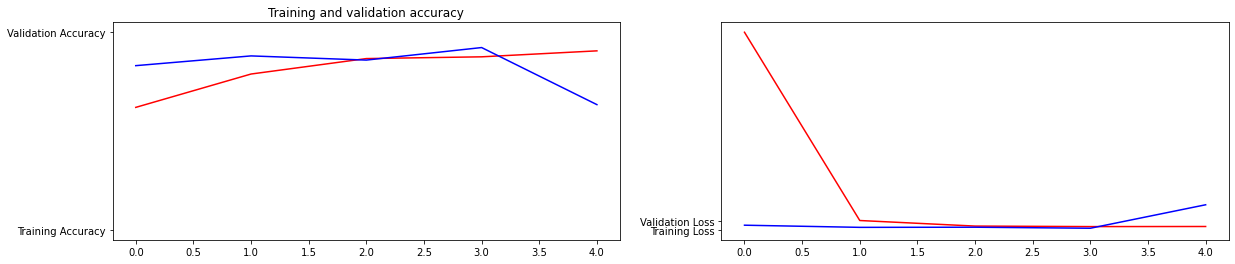

In [ ]:
visualize_results(history)

#### 3.1.2. Two-layer model

In [ ]:
two_layer_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), input_shape=input_shape, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

two_layer_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),\
    loss='binary_crossentropy', metrics=['accuracy'])

history = two_layer_model.fit(train_gen,
                    epochs=5,
                    verbose=1,
                    validation_data=val_gen)

Epoch 1/5
29/29 [==============================] - 46s 2s/step - loss: 4.1079 - accuracy: 0.6892 - val_loss: 0.4048 - val_accuracy: 0.8592
Epoch 2/5
29/29 [==============================] - 46s 2s/step - loss: 0.6476 - accuracy: 0.8188 - val_loss: 0.2900 - val_accuracy: 0.8803
Epoch 3/5
29/29 [==============================] - 47s 2s/step - loss: 0.3650 - accuracy: 0.8845 - val_loss: 0.2005 - val_accuracy: 0.9085
Epoch 4/5
29/29 [==============================] - 45s 2s/step - loss: 0.4087 - accuracy: 0.8650 - val_loss: 0.7124 - val_accuracy: 0.6972
Epoch 5/5
29/29 [==============================] - 45s 2s/step - loss: 0.2192 - accuracy: 0.9290 - val_loss: 0.2988 - val_accuracy: 0.9085


**Two-layer stats:** After 5 epochs, we get a training accuracy of 92.9% and a validation accuracy of 90.9%.

The two-layer model provides better results after 5 epochs compared to the one-layer model.

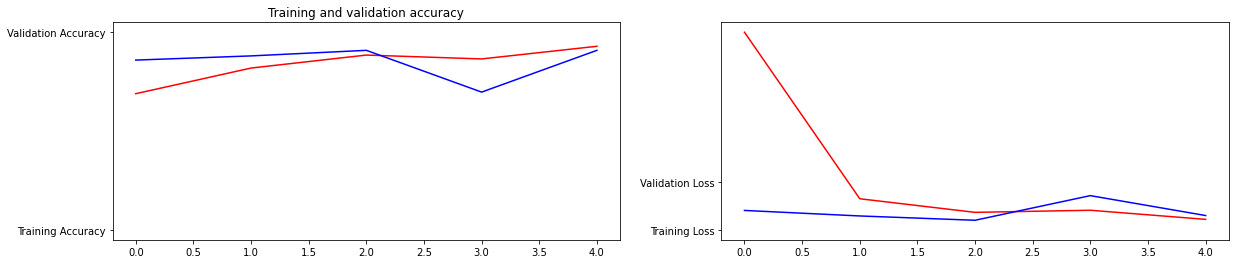

In [ ]:
visualize_results(history)

#### 3.1.3. Three-layer model

In [ ]:
three_layer_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), input_shape=input_shape, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

three_layer_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),\
    loss='binary_crossentropy', metrics=['accuracy'])

history = three_layer_model.fit(train_gen,
                    epochs=5,
                    verbose=1,
                    validation_data=val_gen)

Epoch 1/5
29/29 [==============================] - 27s 881ms/step - loss: 1.1086 - accuracy: 0.6643 - val_loss: 0.5446 - val_accuracy: 0.6197
Epoch 2/5
29/29 [==============================] - 26s 887ms/step - loss: 0.4544 - accuracy: 0.8206 - val_loss: 0.3995 - val_accuracy: 0.8521
Epoch 3/5
29/29 [==============================] - 24s 822ms/step - loss: 0.3455 - accuracy: 0.8703 - val_loss: 0.3559 - val_accuracy: 0.8380
Epoch 4/5
29/29 [==============================] - 24s 818ms/step - loss: 0.4280 - accuracy: 0.8703 - val_loss: 0.2489 - val_accuracy: 0.8873
Epoch 5/5
29/29 [==============================] - 24s 835ms/step - loss: 0.3080 - accuracy: 0.8863 - val_loss: 0.2899 - val_accuracy: 0.8732


**Three-layer stats:** After 5 epochs, we get a training accuracy of 88.6% and a validation accuracy of 87.3%. 

The accuracy is lower than in the case of the two-layer network, suggesting that adding an additional convolution removes relevant data from the neural network. However, in this case the training & validation accuracy seem to converge.

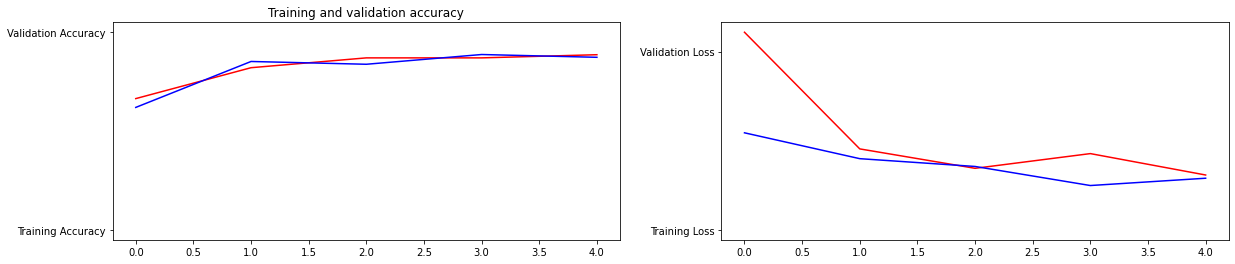

In [ ]:
visualize_results(history)

### 3.2. Hyperparameter tuning

We'll now try to optimize our two-layer neural network which we'll then test on the Kaggle dataset.

In [ ]:
# Create function to personalize hyperparameters for the chosen architecture
def create_model(filter_1=32, filter_2=64, kernel=(3, 3), activation_conv='relu', neurons=512, activation_dense='relu', \
                 optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss="binary_crossentropy"):
  two_layer_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filter_1, kernel, input_shape=(178, 178, 3), activation=activation_conv),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(filter_2, kernel, activation=activation_conv),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(neurons, activation=activation_dense),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])

  two_layer_model.compile(optimizer=optimizer,loss=loss, metrics=['accuracy'])

  history = two_layer_model.fit(train_gen,
                      epochs=5,
                      verbose=1,
                      validation_data=val_gen)
  
  return history

#### 3.2.1. Filter sizes

Epoch 1/5
29/29 [==============================] - 274s 9s/step - loss: 3.3595 - accuracy: 0.6004 - val_loss: 0.5580 - val_accuracy: 0.6620
Epoch 2/5
29/29 [==============================] - 29s 987ms/step - loss: 0.4461 - accuracy: 0.8082 - val_loss: 0.3829 - val_accuracy: 0.8239
Epoch 3/5
29/29 [==============================] - 29s 989ms/step - loss: 0.4214 - accuracy: 0.8490 - val_loss: 0.1956 - val_accuracy: 0.8944
Epoch 4/5
29/29 [==============================] - 29s 981ms/step - loss: 0.3156 - accuracy: 0.8881 - val_loss: 0.3798 - val_accuracy: 0.8662
Epoch 5/5
29/29 [==============================] - 29s 986ms/step - loss: 0.2318 - accuracy: 0.9147 - val_loss: 0.3700 - val_accuracy: 0.8239


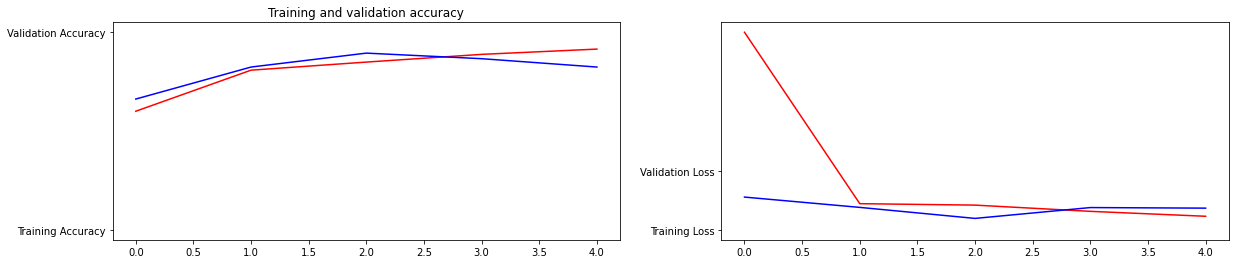

In [ ]:
history = create_model(filter_1=16, filter_2=32)
visualize_results(history)

Epoch 1/5
29/29 [==============================] - 45s 2s/step - loss: 4.1032 - accuracy: 0.5844 - val_loss: 0.6608 - val_accuracy: 0.6127
Epoch 2/5
29/29 [==============================] - 51s 2s/step - loss: 0.9909 - accuracy: 0.7318 - val_loss: 0.3885 - val_accuracy: 0.8732
Epoch 3/5
29/29 [==============================] - 44s 2s/step - loss: 0.6579 - accuracy: 0.8064 - val_loss: 0.2956 - val_accuracy: 0.8732
Epoch 4/5
29/29 [==============================] - 40s 1s/step - loss: 0.2799 - accuracy: 0.8881 - val_loss: 0.2479 - val_accuracy: 0.9085
Epoch 5/5
29/29 [==============================] - 45s 2s/step - loss: 0.4299 - accuracy: 0.8650 - val_loss: 0.2128 - val_accuracy: 0.9225


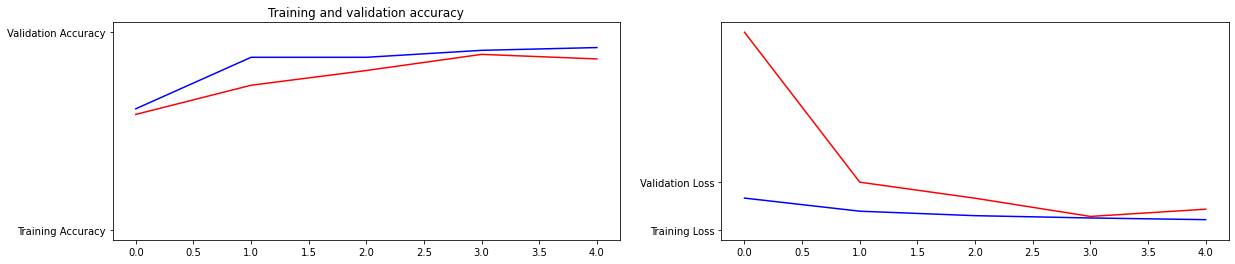

In [ ]:
history = create_model(filter_1=16, filter_2=64)
visualize_results(history)

Epoch 1/5
29/29 [==============================] - 112s 4s/step - loss: 3.9616 - accuracy: 0.6252 - val_loss: 0.4000 - val_accuracy: 0.8803
Epoch 2/5
29/29 [==============================] - 110s 4s/step - loss: 0.5800 - accuracy: 0.7549 - val_loss: 0.4524 - val_accuracy: 0.8732
Epoch 3/5
29/29 [==============================] - 108s 4s/step - loss: 0.5765 - accuracy: 0.7940 - val_loss: 0.2823 - val_accuracy: 0.8732
Epoch 4/5
29/29 [==============================] - 112s 4s/step - loss: 0.3850 - accuracy: 0.8774 - val_loss: 0.2731 - val_accuracy: 0.9014
Epoch 5/5
29/29 [==============================] - 112s 4s/step - loss: 0.3112 - accuracy: 0.8686 - val_loss: 0.2289 - val_accuracy: 0.9085


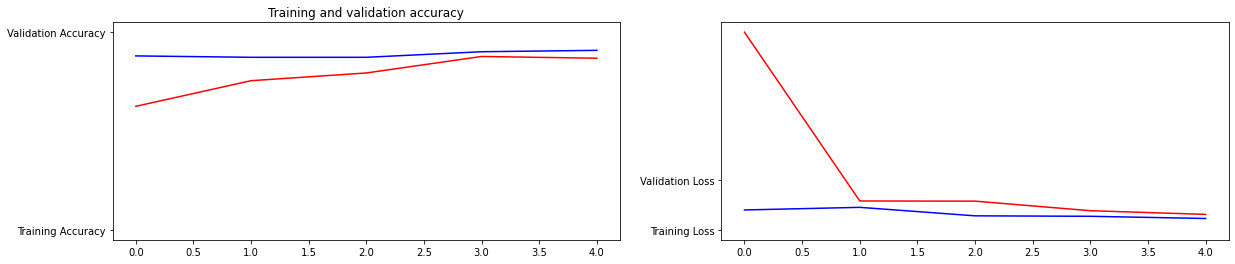

In [ ]:
history = create_model(filter_1=64, filter_2=128)
visualize_results(history)

We notice the best results come from the smaller number of filters: **(32, 64)** and **(16, 32)**. Additionally, it takes longer for the (16, 32) network to fit the training data better than the validation data.

#### 3.2.2. Kernel size

Epoch 1/5
29/29 [==============================] - 44s 2s/step - loss: 3.4988 - accuracy: 0.6128 - val_loss: 0.4733 - val_accuracy: 0.7394
Epoch 2/5
29/29 [==============================] - 48s 2s/step - loss: 0.5543 - accuracy: 0.7602 - val_loss: 0.6021 - val_accuracy: 0.6408
Epoch 3/5
29/29 [==============================] - 45s 2s/step - loss: 0.4756 - accuracy: 0.7922 - val_loss: 0.7160 - val_accuracy: 0.7958
Epoch 4/5
29/29 [==============================] - 45s 2s/step - loss: 0.4485 - accuracy: 0.8313 - val_loss: 0.2792 - val_accuracy: 0.8944
Epoch 5/5
29/29 [==============================] - 45s 2s/step - loss: 0.3038 - accuracy: 0.8828 - val_loss: 0.3593 - val_accuracy: 0.8662


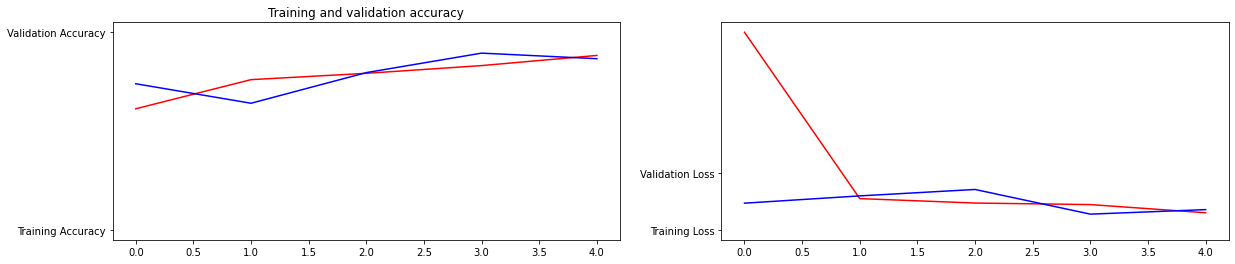

In [ ]:
history = create_model(kernel=(2, 2))
visualize_results(history)

Epoch 1/5
29/29 [==============================] - 61s 2s/step - loss: 5.7850 - accuracy: 0.6643 - val_loss: 6.3623 - val_accuracy: 0.4366
Epoch 2/5
29/29 [==============================] - 60s 2s/step - loss: 1.1778 - accuracy: 0.6980 - val_loss: 1.6684 - val_accuracy: 0.6056
Epoch 3/5
29/29 [==============================] - 62s 2s/step - loss: 0.5874 - accuracy: 0.7798 - val_loss: 0.7621 - val_accuracy: 0.6268
Epoch 4/5
29/29 [==============================] - 58s 2s/step - loss: 0.6137 - accuracy: 0.7655 - val_loss: 0.4348 - val_accuracy: 0.8169
Epoch 5/5
29/29 [==============================] - 60s 2s/step - loss: 0.5163 - accuracy: 0.8188 - val_loss: 0.4225 - val_accuracy: 0.8239


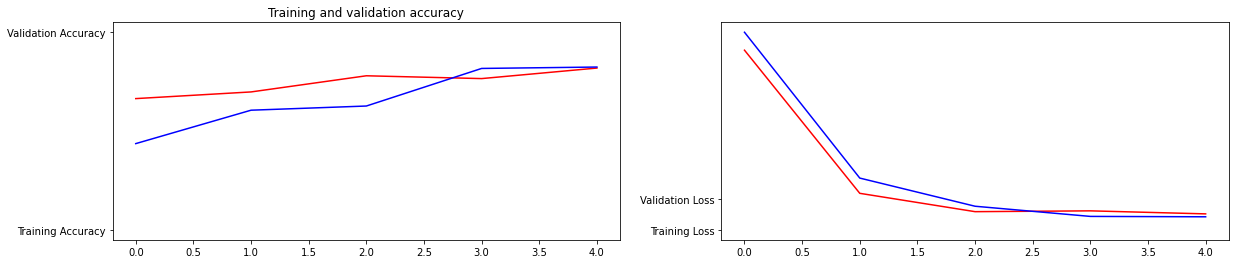

In [ ]:
history = create_model(kernel=(4, 4))
visualize_results(history)

Epoch 1/5
29/29 [==============================] - 72s 2s/step - loss: 4.9304 - accuracy: 0.5915 - val_loss: 0.5619 - val_accuracy: 0.7606
Epoch 2/5
29/29 [==============================] - 73s 3s/step - loss: 0.6974 - accuracy: 0.6838 - val_loss: 0.5461 - val_accuracy: 0.7113
Epoch 3/5
29/29 [==============================] - 72s 2s/step - loss: 0.6957 - accuracy: 0.7265 - val_loss: 0.4726 - val_accuracy: 0.8099
Epoch 4/5
29/29 [==============================] - 73s 3s/step - loss: 0.5491 - accuracy: 0.7886 - val_loss: 0.3815 - val_accuracy: 0.8451
Epoch 5/5
29/29 [==============================] - 73s 3s/step - loss: 0.4883 - accuracy: 0.8437 - val_loss: 0.3623 - val_accuracy: 0.8380


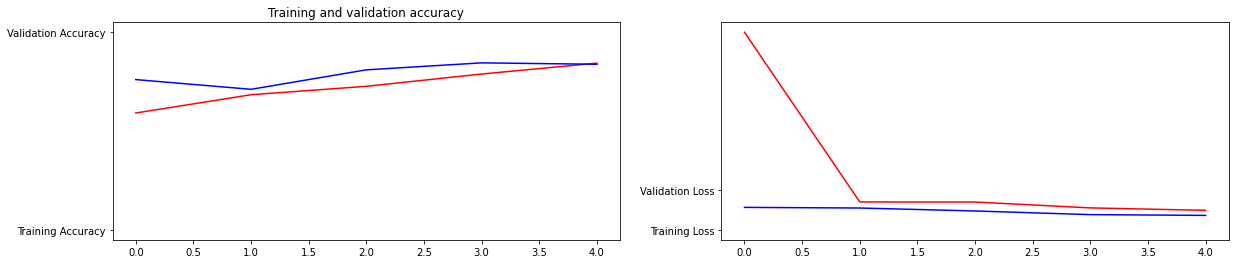

In [ ]:
history = create_model(kernel=(5, 5))
visualize_results(history)

The optimal kernel size across the 2 layers is **(3, 3)**.

#### 3.2.3. Activation function (convolutional layer)

Epoch 1/5
29/29 [==============================] - 58s 2s/step - loss: 10.4085 - accuracy: 0.6536 - val_loss: 0.3251 - val_accuracy: 0.8451
Epoch 2/5
29/29 [==============================] - 59s 2s/step - loss: 1.1914 - accuracy: 0.7567 - val_loss: 0.3472 - val_accuracy: 0.8662
Epoch 3/5
29/29 [==============================] - 62s 2s/step - loss: 0.4454 - accuracy: 0.8561 - val_loss: 0.2154 - val_accuracy: 0.9085
Epoch 4/5
29/29 [==============================] - 72s 2s/step - loss: 0.6617 - accuracy: 0.8046 - val_loss: 0.3612 - val_accuracy: 0.8732
Epoch 5/5
29/29 [==============================] - 62s 2s/step - loss: 0.6717 - accuracy: 0.8384 - val_loss: 0.2117 - val_accuracy: 0.9085


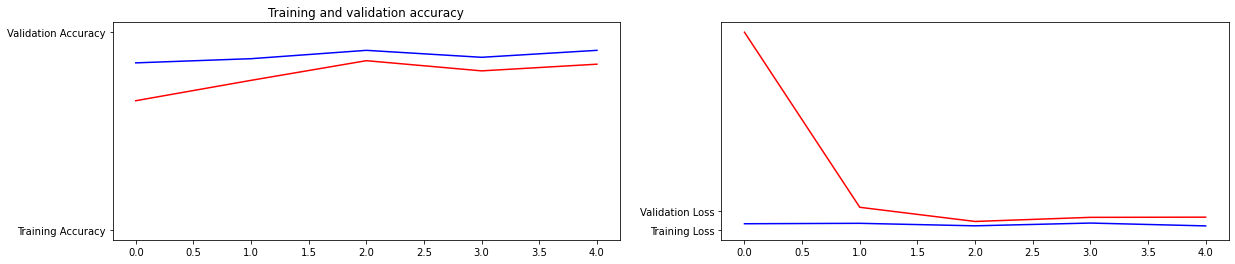

In [ ]:
history = create_model(activation_conv='elu')
visualize_results(history)

Epoch 1/5
29/29 [==============================] - 62s 2s/step - loss: 22.6850 - accuracy: 0.5666 - val_loss: 1.1563 - val_accuracy: 0.7606
Epoch 2/5
29/29 [==============================] - 57s 2s/step - loss: 13.6347 - accuracy: 0.7123 - val_loss: 0.5425 - val_accuracy: 0.6761
Epoch 3/5
29/29 [==============================] - 57s 2s/step - loss: 0.4053 - accuracy: 0.8508 - val_loss: 0.2361 - val_accuracy: 0.8803
Epoch 4/5
29/29 [==============================] - 57s 2s/step - loss: 0.6707 - accuracy: 0.7833 - val_loss: 0.4891 - val_accuracy: 0.8732
Epoch 5/5
29/29 [==============================] - 57s 2s/step - loss: 0.3236 - accuracy: 0.8881 - val_loss: 0.5158 - val_accuracy: 0.7535


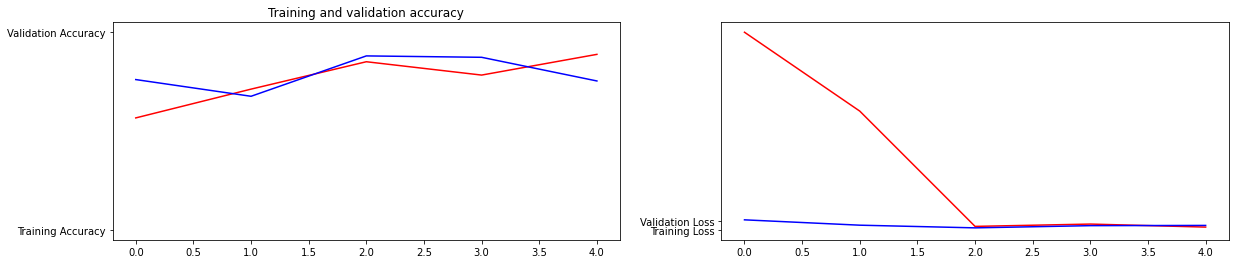

In [ ]:
history = create_model(activation_conv='selu')
visualize_results(history)

Epoch 1/5
29/29 [==============================] - 65s 2s/step - loss: 36.7139 - accuracy: 0.5275 - val_loss: 2.1524 - val_accuracy: 0.4366
Epoch 2/5
29/29 [==============================] - 63s 2s/step - loss: 2.7352 - accuracy: 0.4831 - val_loss: 1.3753 - val_accuracy: 0.4366
Epoch 3/5
29/29 [==============================] - 66s 2s/step - loss: 0.9011 - accuracy: 0.5346 - val_loss: 0.7929 - val_accuracy: 0.5634
Epoch 4/5
29/29 [==============================] - 72s 2s/step - loss: 0.7115 - accuracy: 0.5311 - val_loss: 0.6719 - val_accuracy: 0.5634
Epoch 5/5
29/29 [==============================] - 67s 2s/step - loss: 0.6728 - accuracy: 0.5933 - val_loss: 0.6768 - val_accuracy: 0.7465


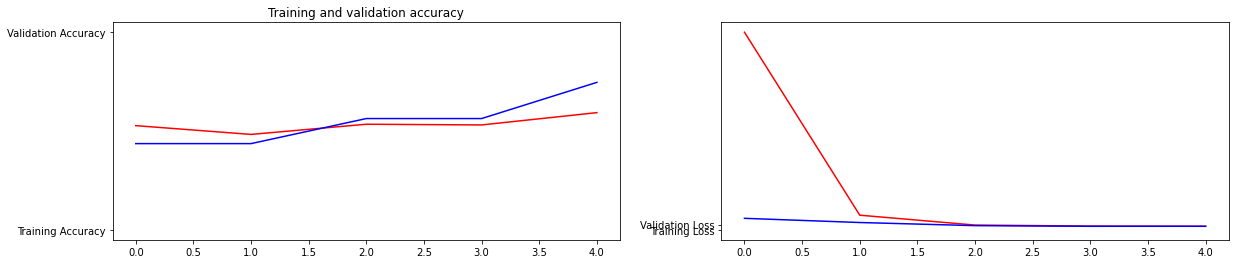

In [ ]:
history = create_model(activation_conv='softplus')
visualize_results(history)

**ReLU** remains the best activation function choice for the convolutional layers.

#### 3.2.4. Number of neurons in the dense layer

Epoch 1/5
29/29 [==============================] - 44s 1s/step - loss: 2.3655 - accuracy: 0.6785 - val_loss: 0.7509 - val_accuracy: 0.6056
Epoch 2/5
29/29 [==============================] - 42s 1s/step - loss: 0.6630 - accuracy: 0.7282 - val_loss: 0.4841 - val_accuracy: 0.7887
Epoch 3/5
29/29 [==============================] - 49s 2s/step - loss: 0.5018 - accuracy: 0.7940 - val_loss: 0.3473 - val_accuracy: 0.8521
Epoch 4/5
29/29 [==============================] - 43s 1s/step - loss: 0.5231 - accuracy: 0.7993 - val_loss: 0.9353 - val_accuracy: 0.7113
Epoch 5/5
29/29 [==============================] - 49s 2s/step - loss: 0.3748 - accuracy: 0.8632 - val_loss: 0.4484 - val_accuracy: 0.8169


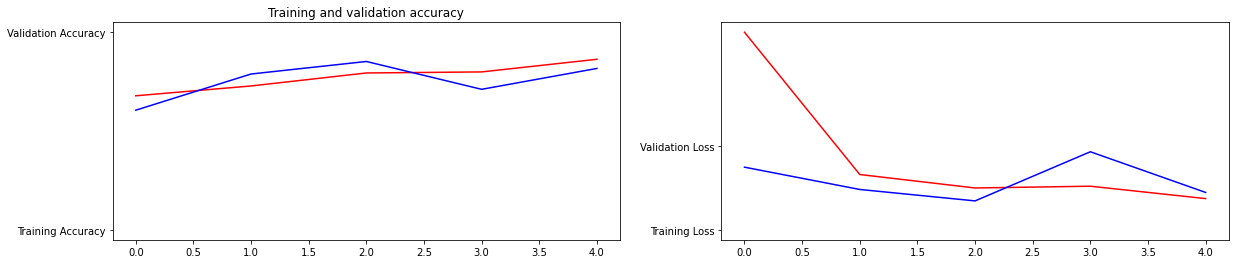

In [ ]:
history = create_model(neurons=256)
visualize_results(history)

Epoch 1/5
29/29 [==============================] - 86s 3s/step - loss: 3.9722 - accuracy: 0.6838 - val_loss: 0.4105 - val_accuracy: 0.8380
Epoch 2/5
29/29 [==============================] - 97s 3s/step - loss: 0.7305 - accuracy: 0.8135 - val_loss: 0.3209 - val_accuracy: 0.8732
Epoch 3/5
29/29 [==============================] - 100s 3s/step - loss: 0.4062 - accuracy: 0.8259 - val_loss: 0.2733 - val_accuracy: 0.8873
Epoch 4/5
29/29 [==============================] - 87s 3s/step - loss: 0.4125 - accuracy: 0.8455 - val_loss: 0.3079 - val_accuracy: 0.8944
Epoch 5/5
29/29 [==============================] - 90s 3s/step - loss: 0.2950 - accuracy: 0.8810 - val_loss: 0.3091 - val_accuracy: 0.8803


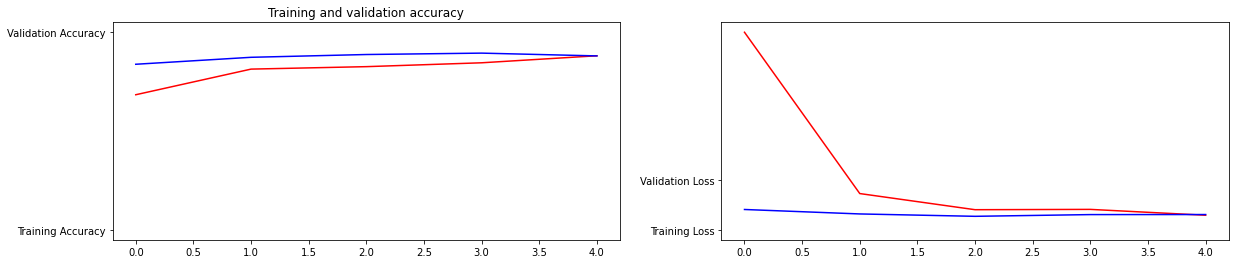

In [ ]:
history = create_model(neurons=1028)
visualize_results(history)

The dense layer with 512 neurons gave the best results.

#### 3.2.5. Activation function (neural network layer)

Epoch 1/5
29/29 [==============================] - 66s 2s/step - loss: 5.0275 - accuracy: 0.5950 - val_loss: 0.5264 - val_accuracy: 0.8028
Epoch 2/5
29/29 [==============================] - 51s 2s/step - loss: 0.7076 - accuracy: 0.6643 - val_loss: 0.9521 - val_accuracy: 0.4366
Epoch 3/5
29/29 [==============================] - 51s 2s/step - loss: 1.2514 - accuracy: 0.7247 - val_loss: 0.4078 - val_accuracy: 0.8169
Epoch 4/5
29/29 [==============================] - 53s 2s/step - loss: 0.7555 - accuracy: 0.7123 - val_loss: 0.5111 - val_accuracy: 0.7113
Epoch 5/5
29/29 [==============================] - 50s 2s/step - loss: 0.4398 - accuracy: 0.7798 - val_loss: 0.4075 - val_accuracy: 0.8099


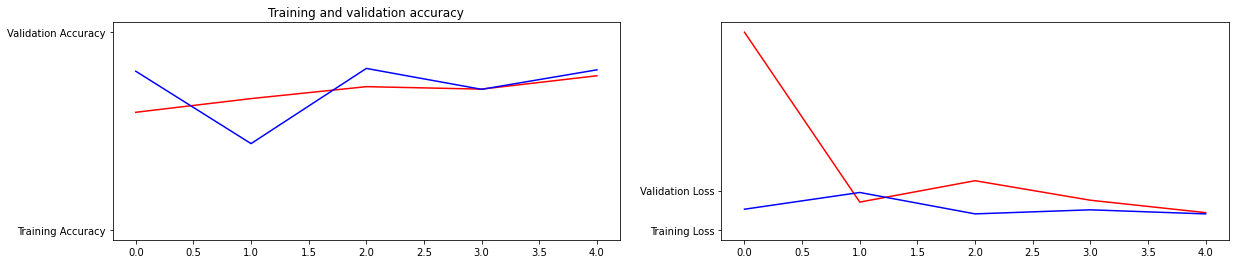

In [ ]:
history = create_model(activation_dense='elu')
visualize_results(history)

Epoch 1/5
29/29 [==============================] - 60s 2s/step - loss: 14.6304 - accuracy: 0.5773 - val_loss: 0.6103 - val_accuracy: 0.5986
Epoch 2/5
29/29 [==============================] - 50s 2s/step - loss: 0.6854 - accuracy: 0.6661 - val_loss: 0.3915 - val_accuracy: 0.8310
Epoch 3/5
29/29 [==============================] - 51s 2s/step - loss: 0.6070 - accuracy: 0.6874 - val_loss: 0.6624 - val_accuracy: 0.6268
Epoch 4/5
29/29 [==============================] - 49s 2s/step - loss: 0.6272 - accuracy: 0.7052 - val_loss: 0.3840 - val_accuracy: 0.8169
Epoch 5/5
29/29 [==============================] - 51s 2s/step - loss: 0.5660 - accuracy: 0.7762 - val_loss: 0.5221 - val_accuracy: 0.8169


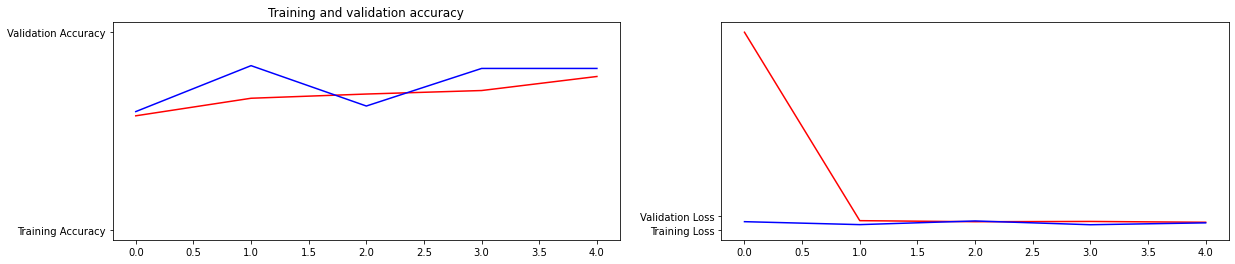

In [ ]:
history = create_model(activation_dense='selu')
visualize_results(history)

Epoch 1/5
29/29 [==============================] - 50s 2s/step - loss: 4.6081 - accuracy: 0.5471 - val_loss: 0.6840 - val_accuracy: 0.5634
Epoch 2/5
29/29 [==============================] - 54s 2s/step - loss: 0.7672 - accuracy: 0.5613 - val_loss: 0.6925 - val_accuracy: 0.5634
Epoch 3/5
29/29 [==============================] - 48s 2s/step - loss: 0.6923 - accuracy: 0.5613 - val_loss: 0.6918 - val_accuracy: 0.5634
Epoch 4/5
29/29 [==============================] - 48s 2s/step - loss: 0.6965 - accuracy: 0.5613 - val_loss: 0.6912 - val_accuracy: 0.5634
Epoch 5/5
29/29 [==============================] - 49s 2s/step - loss: 0.9548 - accuracy: 0.5613 - val_loss: 0.6304 - val_accuracy: 0.5634


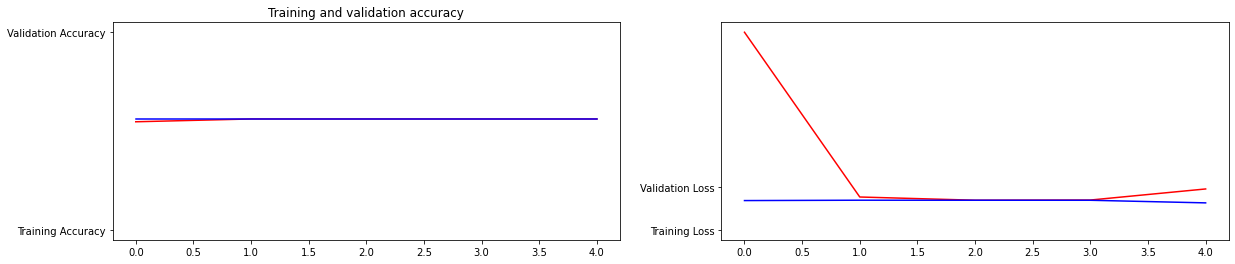

In [ ]:
history = create_model(activation_dense='softplus')
visualize_results(history)

**ReLU** remains the best activation function choice for the dense hidden layer.

#### 3.2.6. Optimizer

Epoch 1/5
29/29 [==============================] - 46s 2s/step - loss: 1.2738 - accuracy: 0.6963 - val_loss: 0.4564 - val_accuracy: 0.8239
Epoch 2/5
29/29 [==============================] - 46s 2s/step - loss: 0.4262 - accuracy: 0.8046 - val_loss: 0.3359 - val_accuracy: 0.8451
Epoch 3/5
29/29 [==============================] - 46s 2s/step - loss: 0.3345 - accuracy: 0.8597 - val_loss: 0.3021 - val_accuracy: 0.8732
Epoch 4/5
29/29 [==============================] - 46s 2s/step - loss: 0.2832 - accuracy: 0.8917 - val_loss: 0.2585 - val_accuracy: 0.9014
Epoch 5/5
29/29 [==============================] - 46s 2s/step - loss: 0.1852 - accuracy: 0.9236 - val_loss: 0.2134 - val_accuracy: 0.9014


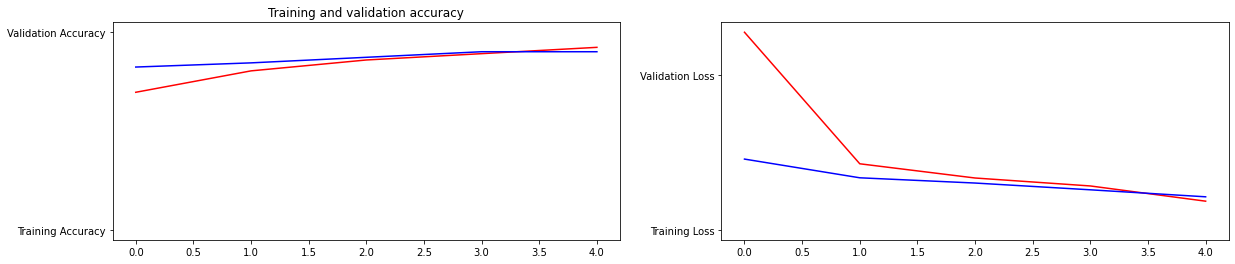

In [ ]:
history = create_model(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
visualize_results(history)

Epoch 1/5
29/29 [==============================] - 57s 2s/step - loss: 0.6693 - accuracy: 0.6199 - val_loss: 0.6464 - val_accuracy: 0.7606
Epoch 2/5
29/29 [==============================] - 47s 2s/step - loss: 0.6425 - accuracy: 0.6643 - val_loss: 0.6195 - val_accuracy: 0.8239
Epoch 3/5
29/29 [==============================] - 47s 2s/step - loss: 0.6118 - accuracy: 0.7496 - val_loss: 0.5942 - val_accuracy: 0.6901
Epoch 4/5
29/29 [==============================] - 48s 2s/step - loss: 0.5856 - accuracy: 0.7513 - val_loss: 0.5817 - val_accuracy: 0.7676
Epoch 5/5
29/29 [==============================] - 48s 2s/step - loss: 0.5681 - accuracy: 0.7726 - val_loss: 0.5460 - val_accuracy: 0.8239


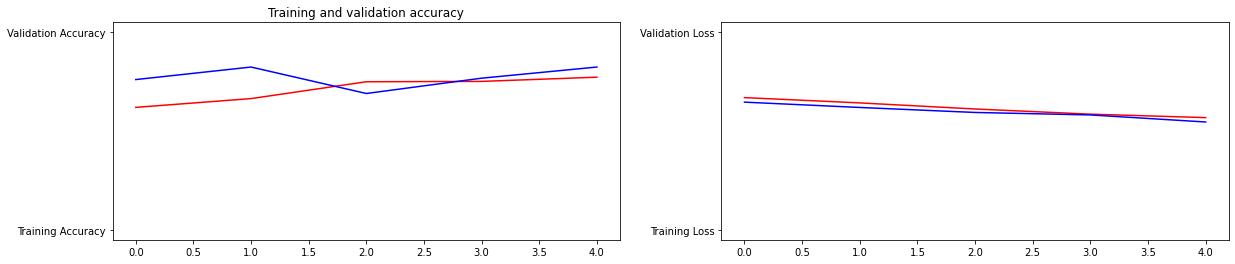

In [ ]:
history = create_model(optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.003)) # learning rate change because the model was converging too slowly
visualize_results(history)

Epoch 1/5
29/29 [==============================] - 47s 2s/step - loss: 0.6418 - accuracy: 0.6448 - val_loss: 0.5955 - val_accuracy: 0.5634
Epoch 2/5
29/29 [==============================] - 45s 2s/step - loss: 0.5173 - accuracy: 0.7513 - val_loss: 0.4603 - val_accuracy: 0.7887
Epoch 3/5
29/29 [==============================] - 45s 2s/step - loss: 0.4022 - accuracy: 0.8330 - val_loss: 0.3206 - val_accuracy: 0.8662
Epoch 4/5
29/29 [==============================] - 45s 2s/step - loss: 0.3386 - accuracy: 0.8579 - val_loss: 0.2882 - val_accuracy: 0.8732
Epoch 5/5
29/29 [==============================] - 44s 2s/step - loss: 0.3738 - accuracy: 0.8774 - val_loss: 0.2451 - val_accuracy: 0.9014


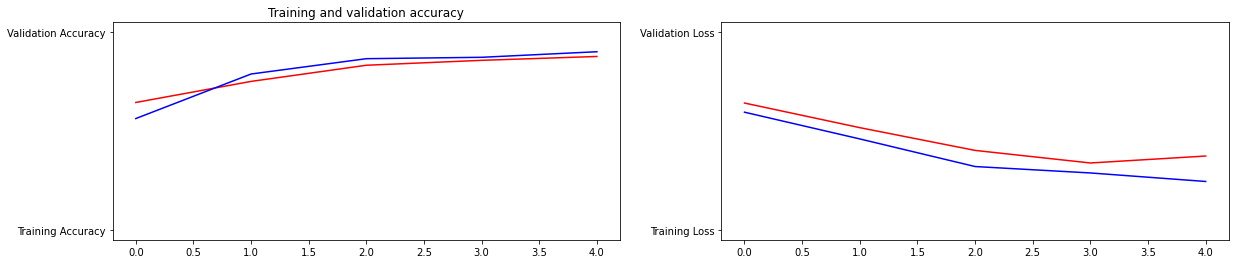

In [ ]:
history = create_model(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01))
visualize_results(history)

Epoch 1/5
29/29 [==============================] - 48s 2s/step - loss: 2.4036 - accuracy: 0.6430 - val_loss: 0.4384 - val_accuracy: 0.8310
Epoch 2/5
29/29 [==============================] - 45s 2s/step - loss: 0.3474 - accuracy: 0.8490 - val_loss: 0.2728 - val_accuracy: 0.8592
Epoch 3/5
29/29 [==============================] - 46s 2s/step - loss: 0.2694 - accuracy: 0.8792 - val_loss: 0.2311 - val_accuracy: 0.8944
Epoch 4/5
29/29 [==============================] - 45s 2s/step - loss: 0.2280 - accuracy: 0.9076 - val_loss: 0.2434 - val_accuracy: 0.8873
Epoch 5/5
29/29 [==============================] - 46s 2s/step - loss: 0.2240 - accuracy: 0.9112 - val_loss: 0.2072 - val_accuracy: 0.9296


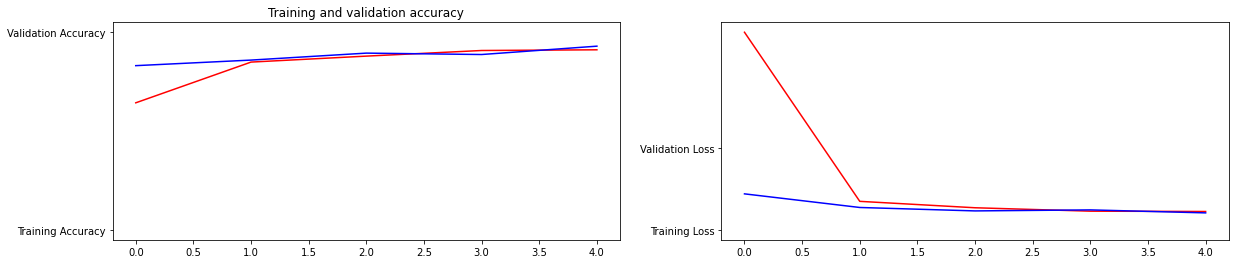

In [ ]:
history = create_model(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001))
visualize_results(history)

Epoch 1/5
29/29 [==============================] - 73s 2s/step - loss: 1.8145 - accuracy: 0.6679 - val_loss: 0.3863 - val_accuracy: 0.8169
Epoch 2/5
29/29 [==============================] - 60s 2s/step - loss: 0.4290 - accuracy: 0.8295 - val_loss: 0.2529 - val_accuracy: 0.8873
Epoch 3/5
29/29 [==============================] - 67s 2s/step - loss: 0.3943 - accuracy: 0.8526 - val_loss: 0.2578 - val_accuracy: 0.8873
Epoch 4/5
29/29 [==============================] - 63s 2s/step - loss: 0.3937 - accuracy: 0.8792 - val_loss: 0.8212 - val_accuracy: 0.6761
Epoch 5/5
29/29 [==============================] - 63s 2s/step - loss: 0.2134 - accuracy: 0.9130 - val_loss: 0.2173 - val_accuracy: 0.9085


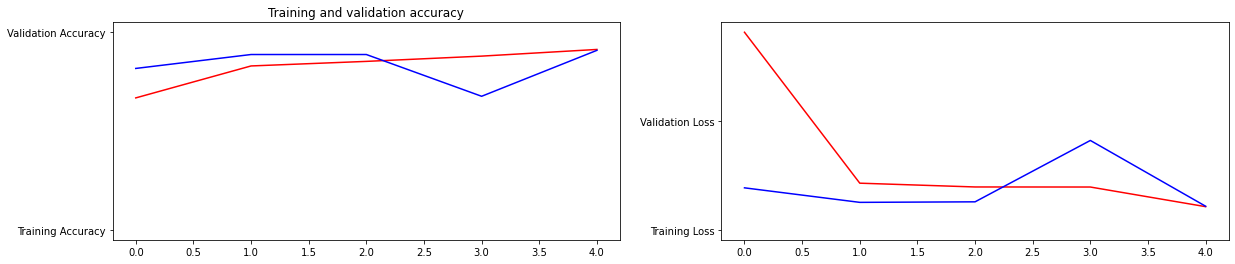

In [ ]:
history = create_model(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001))
visualize_results(history)

Epoch 1/5
29/29 [==============================] - 53s 2s/step - loss: 0.6914 - accuracy: 0.5400 - val_loss: 0.6915 - val_accuracy: 0.5634
Epoch 2/5
29/29 [==============================] - 47s 2s/step - loss: 0.6911 - accuracy: 0.5613 - val_loss: 0.6903 - val_accuracy: 0.5634
Epoch 3/5
29/29 [==============================] - 48s 2s/step - loss: 0.6901 - accuracy: 0.5613 - val_loss: 0.6895 - val_accuracy: 0.5634
Epoch 4/5
29/29 [==============================] - 47s 2s/step - loss: 0.6895 - accuracy: 0.5613 - val_loss: 0.6892 - val_accuracy: 0.5634
Epoch 5/5
29/29 [==============================] - 47s 2s/step - loss: 0.6892 - accuracy: 0.5613 - val_loss: 0.6888 - val_accuracy: 0.5634


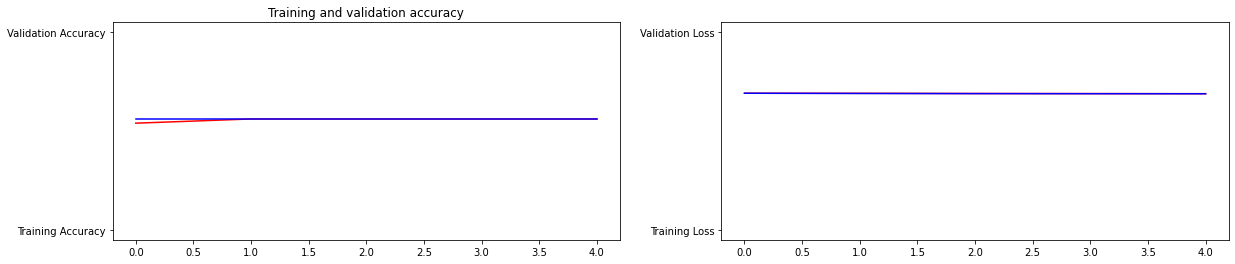

In [ ]:
history = create_model(optimizer=tf.keras.optimizers.Ftrl(learning_rate=0.01)) # learning rate changed because of plateau issues
visualize_results(history)

The **Nadam optimizer** performs best on training data, whereas the **Adamax optimizer** performs best on both training & validation data. The latter also shows a linear increase in accuracy across both sets, therefore it's more likely to converge. The **Ftrl optimizer** was likely stuck in a local minimum, which could be tackled by automatically adjusting the learning rate when plateaus are met. However, as we got good results using Adamax, we will use it as our optimizing function.

#### 3.2.7. Loss function

Epoch 1/5
29/29 [==============================] - 51s 2s/step - loss: 6.8985 - accuracy: 0.5506 - val_loss: 7.0375 - val_accuracy: 0.5634
Epoch 2/5
29/29 [==============================] - 52s 2s/step - loss: 7.0713 - accuracy: 0.5613 - val_loss: 7.0375 - val_accuracy: 0.5634
Epoch 3/5
29/29 [==============================] - 52s 2s/step - loss: 7.0713 - accuracy: 0.5613 - val_loss: 7.0375 - val_accuracy: 0.5634
Epoch 4/5
29/29 [==============================] - 53s 2s/step - loss: 7.0713 - accuracy: 0.5613 - val_loss: 7.0375 - val_accuracy: 0.5634
Epoch 5/5
29/29 [==============================] - 52s 2s/step - loss: 7.0713 - accuracy: 0.5613 - val_loss: 7.0375 - val_accuracy: 0.5634


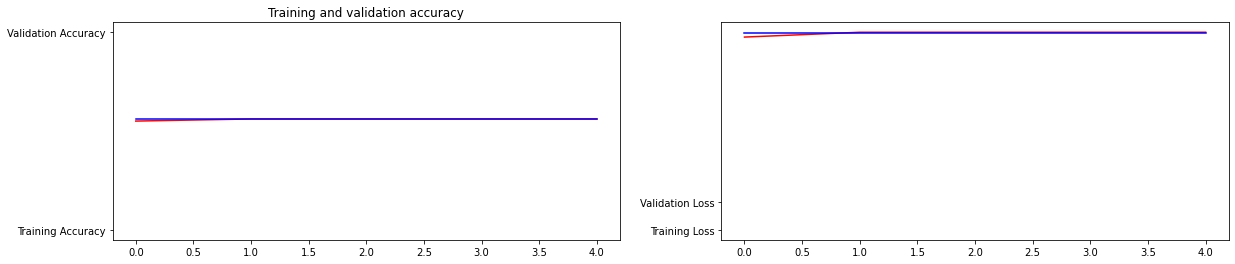

In [ ]:
history = create_model(loss='poisson')
visualize_results(history)

Epoch 1/5
29/29 [==============================] - 52s 2s/step - loss: 0.0114 - accuracy: 0.4440 - val_loss: -9.0806e-07 - val_accuracy: 0.4366
Epoch 2/5
29/29 [==============================] - 52s 2s/step - loss: -9.0467e-07 - accuracy: 0.4387 - val_loss: -9.0806e-07 - val_accuracy: 0.4366
Epoch 3/5
29/29 [==============================] - 57s 2s/step - loss: -9.0467e-07 - accuracy: 0.4387 - val_loss: -9.0806e-07 - val_accuracy: 0.4366
Epoch 4/5
29/29 [==============================] - 52s 2s/step - loss: -9.0467e-07 - accuracy: 0.4387 - val_loss: -9.0806e-07 - val_accuracy: 0.4366
Epoch 5/5
29/29 [==============================] - 52s 2s/step - loss: -9.0467e-07 - accuracy: 0.4387 - val_loss: -9.0806e-07 - val_accuracy: 0.4366


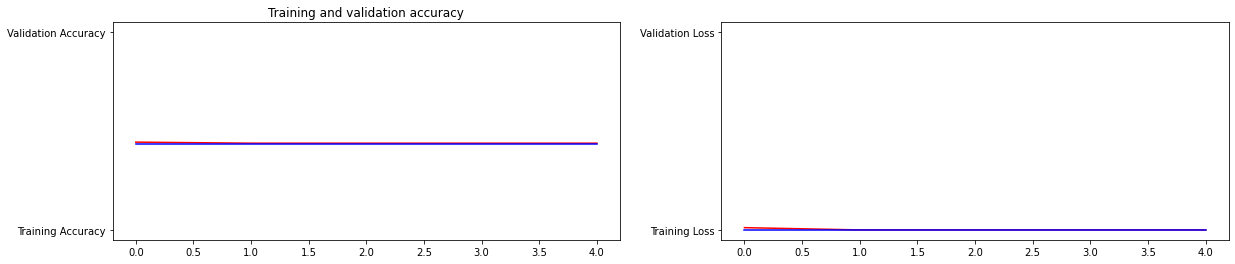

In [ ]:
history = create_model(loss='kl_divergence')
visualize_results(history)

Both loss functions plateau when the optimizer is RMSprop with a learning rate of 0.001. This suggests that gradient descent found a local minimum. We can test the loss functions with different optimizers but we'll stick with the current best match as it achieved good accuracy results.

#### 3.2.8. Number of epochs

To optimize the number of epochs, we'll use the best hyperparameters we had from previous tests and use a callback to stop training when the accuracy exceeds 99%.

In [ ]:
class newCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') is not None and logs.get('accuracy') > 0.99:
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True  

In [ ]:
callbacks = newCallback()

two_layer_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), input_shape=input_shape, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

two_layer_model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),\
    loss='binary_crossentropy', metrics=['accuracy'])

history = two_layer_model.fit(train_gen,
                    epochs=30,
                    verbose=1,
                    validation_data=val_gen,
                    callbacks=callbacks)

Epoch 1/30
29/29 [==============================] - 180s 6s/step - loss: 1.8955 - accuracy: 0.5471 - val_loss: 0.5883 - val_accuracy: 0.7887
Epoch 2/30
29/29 [==============================] - 27s 926ms/step - loss: 0.4754 - accuracy: 0.8011 - val_loss: 0.3637 - val_accuracy: 0.8380
Epoch 3/30
29/29 [==============================] - 27s 922ms/step - loss: 0.3466 - accuracy: 0.8366 - val_loss: 0.2959 - val_accuracy: 0.8662
Epoch 4/30
29/29 [==============================] - 27s 919ms/step - loss: 0.3042 - accuracy: 0.8668 - val_loss: 0.3013 - val_accuracy: 0.8803
Epoch 5/30
29/29 [==============================] - 27s 927ms/step - loss: 0.2582 - accuracy: 0.8952 - val_loss: 0.2310 - val_accuracy: 0.9014
Epoch 6/30
29/29 [==============================] - 27s 932ms/step - loss: 0.2258 - accuracy: 0.8934 - val_loss: 0.2254 - val_accuracy: 0.9085
Epoch 7/30
29/29 [==============================] - 27s 924ms/step - loss: 0.1894 - accuracy: 0.9378 - val_loss: 0.2046 - val_accuracy: 0.9225
E

We'll use the pair that has the highest accuracy, i.e. the pair at epoch 18, (98.6% training, 95.1% validation).

### 3.3. Model evaluation

We'll evaluate the final neural network on the Kaggle dataset.

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), input_shape=input_shape, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),\
    loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_gen,
                    epochs=18,
                    verbose=1,
                    validation_data=val_gen)

Epoch 1/18
29/29 [==============================] - 338s 12s/step - loss: 1.1223 - accuracy: 0.7087 - val_loss: 0.4290 - val_accuracy: 0.8028
Epoch 2/18
29/29 [==============================] - 45s 2s/step - loss: 0.3881 - accuracy: 0.8277 - val_loss: 0.3250 - val_accuracy: 0.8451
Epoch 3/18
29/29 [==============================] - 45s 2s/step - loss: 0.3282 - accuracy: 0.8579 - val_loss: 0.2792 - val_accuracy: 0.8521
Epoch 4/18
29/29 [==============================] - 45s 2s/step - loss: 0.2795 - accuracy: 0.8970 - val_loss: 0.2596 - val_accuracy: 0.8873
Epoch 5/18
29/29 [==============================] - 45s 2s/step - loss: 0.2480 - accuracy: 0.8970 - val_loss: 0.2661 - val_accuracy: 0.8873
Epoch 6/18
29/29 [==============================] - 45s 2s/step - loss: 0.2131 - accuracy: 0.9290 - val_loss: 0.1953 - val_accuracy: 0.9296
Epoch 7/18
29/29 [==============================] - 45s 2s/step - loss: 0.1943 - accuracy: 0.9272 - val_loss: 0.2763 - val_accuracy: 0.8803
Epoch 8/18
29/29 [

In [19]:
# Save trained model architecture and weights
json_model = model.to_json()
with open('model.json', 'w') as outfile:
    outfile.write(json_model)

model.save_weights("simple_model_weights.h5")

In [ ]:
kaggle_dir = os.path.join(drive, "kaggle_data")
kaggle_train_dir = os.path.join(kaggle_dir, "training")
kaggle_g_train_dir = os.path.join(kaggle_train_dir, "glaucoma")
kaggle_n_train_dir = os.path.join(kaggle_train_dir, "normal")
kaggle_val_dir = os.path.join(kaggle_dir, "validation")
kaggle_g_val_dir = os.path.join(kaggle_val_dir, "glaucoma")
kaggle_n_val_dir = os.path.join(kaggle_val_dir, "normal")

In [ ]:
X_g, y_g = get_testing_data([kaggle_g_train_dir, kaggle_g_val_dir], (178, 178))
X_n, y_n = get_testing_data([kaggle_n_train_dir, kaggle_n_val_dir], (178, 178))

y_g_pred = model.predict(X_g, batch_size=20)
y_n_pred = model.predict(X_n, batch_size=20)

In [ ]:
print(y_g.shape)
print(y_n.shape)

(101,)
(300,)


In [ ]:
# Change data type from float to int
y_g_pred = y_g_pred.astype(int)
y_n_pred = y_n_pred.astype(int)

# Concatenate the dataframes for the accuracy analysis
y_test = np.hstack([y_g, y_n])
print(y_test.shape)
y_test_pred = np.vstack([y_g_pred, y_n_pred])
print(y_test_pred.shape)

(401,)
(401, 1)


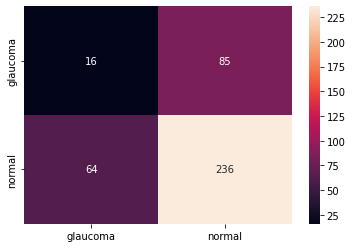

Glaucoma prediction accuracy: 15.84 %
Normal prediction accuracy: 78.67 %


In [ ]:
# Visualize results
draw_conf_matrix(y_test, y_test_pred)

The very low accuracy in glaucoma detection is likely due to the fact that we've tested our model on the full-sized images in the Kaggle dataset, which are very different from the training images. The latter have been previously cropped[$^{[1]}$](https://biomedical-engineering-online.biomedcentral.com/articles/10.1186/s12938-019-0649-y), so they do not have the majority of the black background that the Kaggle images have and they are centred around the optic nerve head / optic disc. 

Therefore, we'll crop the images so they more closely resemble our training dataset. The model evaluation on the cropped images can be found in the [ACRIMA models evaluation](https://github.com/sabinagio/do-you-see-what-AI-see/blob/master/scripts/4-acrima-models-evaluation.ipynb) notebook.

### 3.4. References

[1] Diaz-Pinto, A., Morales, S., Naranjo, V. et al. CNNs for automatic glaucoma assessment using fundus images: an extensive validation. BioMed Eng OnLine 18, 29 (2019). https://doi.org/10.1186/s12938-019-0649-y